# Post-fire Vegetation Recovery Analysis
Christina Appleby  
GEOL 6628

## Introduction
The Cold Fire (Northern California) started due to lightning on June 21, 2008. This project examines how burn severity and topography affect post-fire vegetation recovery of the Cold Fire burn scar.

## Data Sources
* Landsat ARD imagery obtained from __[USGS Earth Explorer](https://earthexplorer.usgs.gov/)__ from 2008-2022 (excluding 2012)
* Fire perimeter data from __[CALFIRE](https://frap.fire.ca.gov/mapping/gis-data/)__ for study area
* SRTM  void-filled DEM from Earth Explorer

## Preparation
* In Windows File Explorer, create a folder for Landsat data.  
* Inside that folder, create an 'unclipped' folder and put Landsat data/folders in there.  
<div>
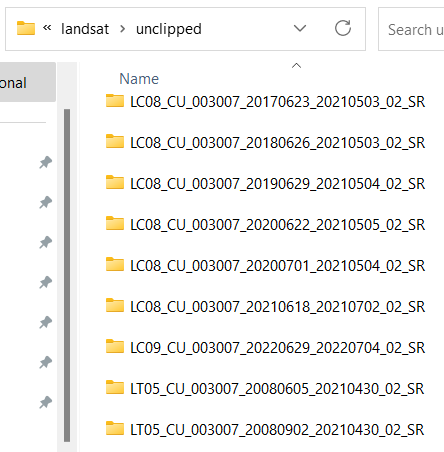
</div>
* The rest of the necessary folders will be created along the way.

* Also inside the Landsat folder, create a 'processed' folder to put reprojected, clipped, and stacked rasters into.  
<div>
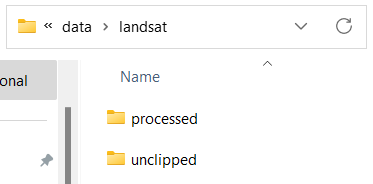
</div>
<br>
* Shapefile of study area is needed to clip the rasters.
    + Fire perimeter features imported into ArcGIS (can also use QGIS), Cold Fire was selected and a 300m buffer was added, and then exported as shapefile.
    + For convenience, the shapefile used for this project is in the desired CRS (NAD 1983 UTM Zone 10N).
    + The shapefile CRS is used to reproject the Landsat rasters.

In [1]:
import os
import glob
import geopandas as gpd
import pandas as pd
import numpy as np
import xarray as xr
import rioxarray as rxr
import earthpy as et #remove?
import earthpy.spatial as es #remove?
import earthpy.plot as ep
import richdem as rd #remove?
import rasterio
import rasterio.mask
import matplotlib.pyplot as plt
import matplotlib.image as mpimg #remove?
import matplotlib.colors as colors #remove?
import imageio #remove?

from rasterio.crs import CRS #remove?
from rasterio.plot import show, show_hist #remove show_hist?
from rasterio.warp import calculate_default_transform, reproject, Resampling
from osgeo import gdal
from scipy import stats
from shapely.geometry import mapping
from matplotlib.colors import ListedColormap, BoundaryNorm #remove bn?

## Reproject, clip, stack, and export Landsat rasters using rioxarray and  xarray

In [17]:
# path to data folder
path = r"C:\Users\cowsp\OneDrive\ISU\Spring_23\GEOL6628\final_project\data"

# path of folder containing Landsat data
ls_path = os.path.join(path, 'landsat')

# path to unclipped data
unclip_path = os.path.join(ls_path, 'unclipped')

# path to folder for data after reprojecting, clipping, and stacking
proc_path = os.path.join(ls_path, 'processed')

# set path to shapefile for clipping
shp_clip = r"C:\Users\cowsp\OneDrive\ISU\Spring_23\GEOL6628\final_project\data\cold_fire_per_300m_buff\cold_fire_per_300m_buff.shp"

In [3]:
# read shapefile with geopandas
shpfile = gpd.read_file(shp_clip)

# get list of Landsat folders in unclipped folder
folders = os.listdir(unclip_path)

print(folders)

['LC08_CU_003007_20130628_20210501_02_SR', 'LC08_CU_003007_20140622_20210501_02_SR', 'LC08_CU_003007_20150625_20210502_02_SR', 'LC08_CU_003007_20160620_20210502_02_SR', 'LC08_CU_003007_20170623_20210503_02_SR', 'LC08_CU_003007_20180626_20210503_02_SR', 'LC08_CU_003007_20190629_20210504_02_SR', 'LC08_CU_003007_20200701_20210504_02_SR', 'LC08_CU_003007_20210618_20210702_02_SR', 'LC09_CU_003007_20220629_20220704_02_SR', 'LT05_CU_003007_20080605_20210430_02_SR', 'LT05_CU_003007_20080902_20210430_02_SR', 'LT05_CU_003007_20090624_20210430_02_SR', 'LT05_CU_003007_20100706_20210430_02_SR', 'LT05_CU_003007_20110716_20210501_02_SR']


In [87]:
for folder in folders:
    # create folder path
    landsat = os.path.join(unclip_path, folder)
    # change working directory to that path
    os.chdir(landsat)
    
    # get only the bands we need from the Landsat folder
    # for Landsat 8 & 9 data, we need bands 4 & 5 for NDVI
    if folder.startswith('LC08') or folder.startswith('LC09'):
        rasters = glob.glob('*[45].TIF')
    # for Landsat 5 data, we need bands 3 & 4 for NDVI and 4 & 7 for NBR
    # only need to calculate NBR for 2008
    elif "2008" in folder:
        rasters = glob.glob('*[347].TIF')
    else:
        rasters = glob.glob('*[34].TIF')
        
    # sort rasters to ensure the bands are in order
    rasters.sort()
        
    # create filename and output path for stacked rasters
    # needs to be done before rasters are reprojected and clipped
    # use first raster
    raster = rasters[0]
    
    # create raster name L***_YYYY_MM_DD to use when stacking and exporting
    rst_name = raster[:5] + raster[15:19] + '_' + raster[19:21] + '_' + raster[21:23] + '.tif'
    
    # create output path
    out_path = os.path.join(proc_path, rst_name)
    
    # reproject and clip each raster, replace in list
    for i in range(len(rasters)):
        # open raster
        src = rxr.open_rasterio(rasters[i])
        
        # reproject using shapefile CRS
        proj = src.rio.reproject(shpfile.crs)
        
        # clip using shapefile
        clip = proj.rio.clip(shpfile.geometry.apply(mapping), all_touched=True)
        
        # mask pixels outside of shapefile boundary
        valid_range = (0, clip.max())
        if valid_range:
            mask = ((clip == valid_range[0]) | (clip > valid_range[1]))
            rasters[i] = clip.where(~xr.where(mask, True, False))
            
    # stack raster bands
    stack = xr.concat(rasters, dim='band')

    # export stacked rasters
    stack.rio.to_raster(out_path)

AttributeError: 'str' object has no attribute 'sort'

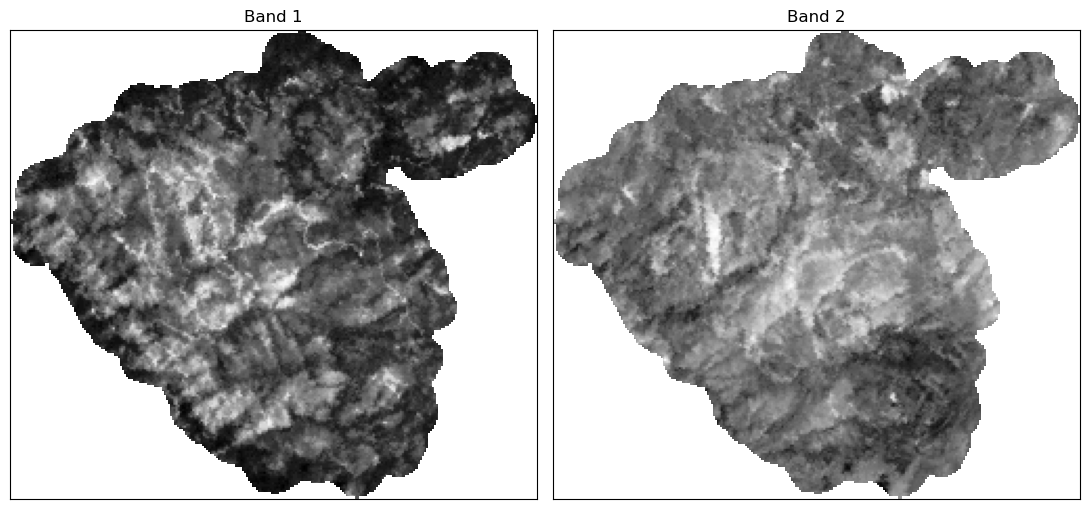

In [6]:
# plot last stack of rasters processed - note the bands have been renumbered
ep.plot_bands(stack,
              figsize=(11, 6),
              cols=2,
              cbar=False)
plt.show()

## Calculate NBR and dNBR for year of fire using rasterio and classify according to USGS burn severity levels using rioxarray and xarray
The Cold Fire started on June 21, 2008; pre-fire Landsat data is from June 5, 2008. It was declared contained on August 21, 2008; post-fire Landsat data is from September 2, 2008.<br><br>
(NIR - SWIR) / (NIR + SWIR)  
In Landsat 5, NBR = (Band 4 – Band 7) / (Band 4 + Band 7).  

In [4]:
# Landsat stack from before the fire
pre_fire_path = r"C:\Users\cowsp\OneDrive\ISU\Spring_23\GEOL6628\final_project\data\landsat\processed\LT05_2008_06_05.tif"

# Landsat stack from after the fire in 2008
post_fire_path = r"C:\Users\cowsp\OneDrive\ISU\Spring_23\GEOL6628\final_project\data\landsat\processed\LT05_2008_09_02.tif"

# create folder for calculated rasters
calc_path = os.path.join(ls_path, 'calculated')
os.mkdir(calc_path)

Bands were renumbered in previous section but were stacked in order.  
Red = Band 1  
NIR = Band 2  
MIR = Band 3

In [20]:
# load NIR and MIR bands pre-fire
pre_fire_data = rxr.open_rasterio(pre_fire_path)

# load NIR and MIR bands post-fire
post_fire_data = rxr.open_rasterio(post_fire_path)

In [24]:
# allow division by zero for NBR calculation

# calculate NBR pre-fire
pre_nbr = (pre_fire_data[1] - pre_fire_data[2]) / (pre_fire_data[1] + pre_fire_data[2])

# calculate NBR post-fire
post_nbr = (post_fire_data[1] - post_fire_data[2]) / (post_fire_data[1] + post_fire_data[2])

<Axes: title={'center': 'Landsat derived Normalized Burn Ratio\n Post Cold Fire'}>

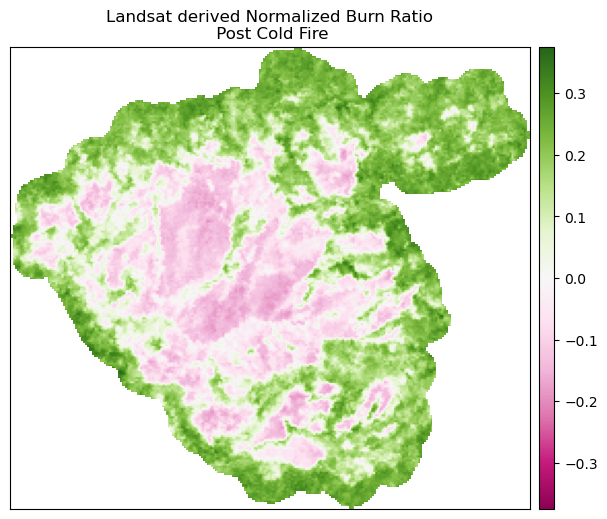

In [36]:
# plot post-NBR
fig, ax = plt.subplots(figsize=(12, 6))

ep.plot_bands(post_nbr,
              cmap='PiYG',
              vmin=-post_nbr.max(),
              vmax=post_nbr.max(),
              ax=ax,
              title="Landsat-derived Normalized Burn Ratio\n Post Cold Fire")

<Axes: title={'center': 'Differenced Normalized Burn Ratio\n Post Cold Fire'}>

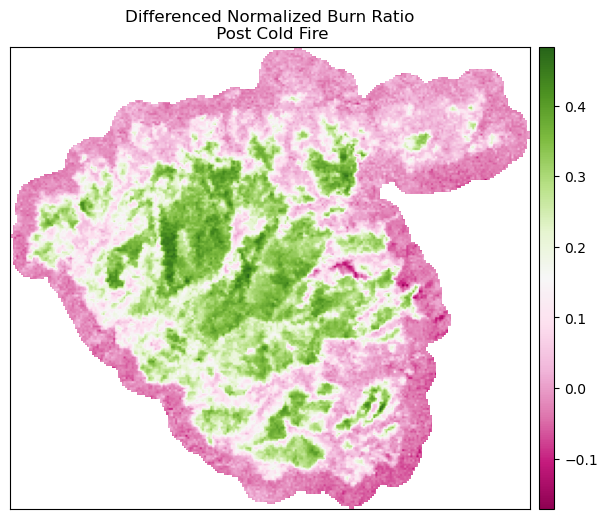

In [70]:
# calculate dNBR
dnbr = pre_nbr - post_nbr

# plot dNBR
fig, ax = plt.subplots(figsize=(12, 6))

ep.plot_bands(dnbr,
              cmap='PiYG',
              vmin=dnbr.min(),
              vmax=dnbr.max(),
              ax=ax,
              title="Differenced Normalized Burn Ratio\n Post Cold Fire")

In [60]:
# find min and max values to reclassify dNBR using USGS burn severity levels
print(dnbr.max(), dnbr.min())

<xarray.DataArray ()>
array(0.48286535)
Coordinates:
    spatial_ref  int32 0 <xarray.DataArray ()>
array(-0.17135951)
Coordinates:
    spatial_ref  int32 0


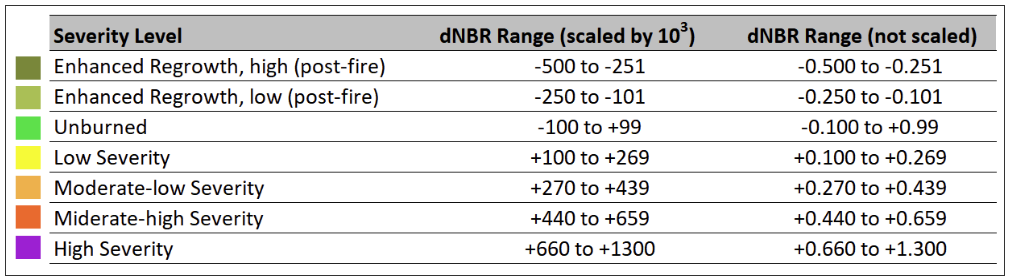

In [50]:
# create class bins
class_bins = [-np.inf, -0.1, 0.1, 0.27, 0.44, np.inf]

# reclassify raster using bins
dnbr_class = xr.apply_ufunc(np.digitize, dnbr, class_bins)

# mask pixels outside of fire boundary
dnbr_class_mask = dnbr_class.where(dnbr_class != 6)

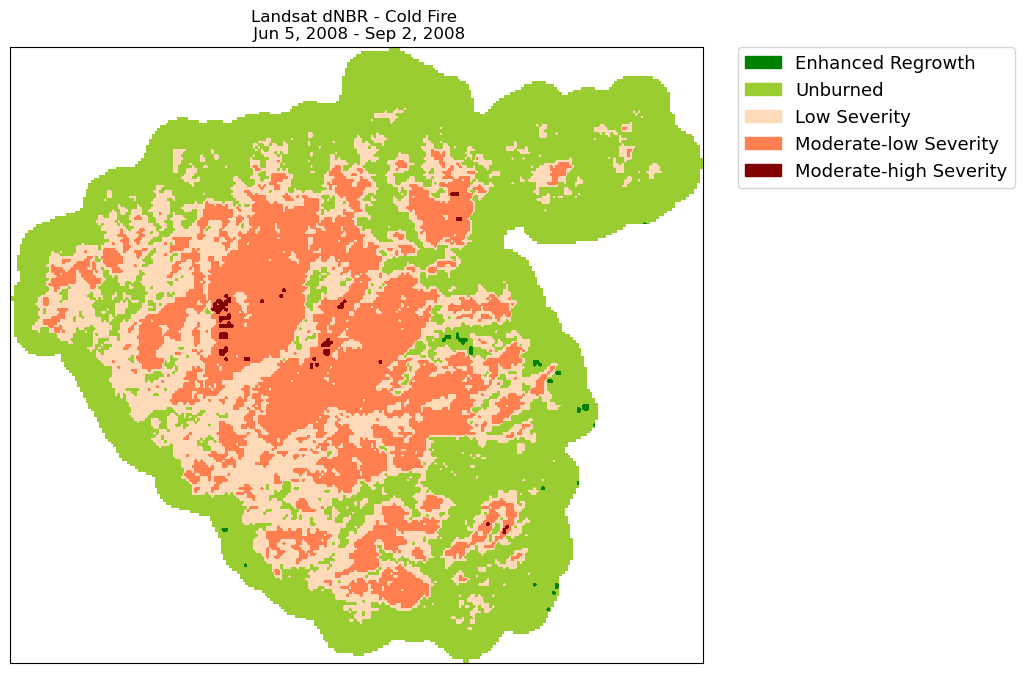

In [78]:
# plot dNBR classification

# legend
# category names
dnbr_cat_names = ["Enhanced Regrowth",
                  "Unburned",
                  "Low Severity",
                  "Moderate-low Severity",
                  "Moderate-high Severity"]

# category colors
dnbr_colors = ["g",
              "yellowgreen",
              "peachpuff",
              "coral",
              "maroon"]
nbr_cmap = ListedColormap(dnbr_colors)

# plot dNBR
fig, ax = plt.subplots(figsize=(10, 8))

classes = np.unique(dnbr_class_mask)
classes = classes.tolist()[:5]

ep.plot_bands(dnbr_class_mask,
              cmap=nbr_cmap,
              vmin=1,
              vmax=5,
              title="Landsat dNBR - Cold Fire \n Jun 5, 2008 - Sep 2, 2008",
              cbar=False,
              scale=False,
              ax=ax)

ep.draw_legend(im_ax=ax.get_images()[0],
               classes=classes,
               titles=dnbr_cat_names)

plt.show()

In [84]:
# export rasters
pre_nbr.rio.to_raster(os.path.join(calc_path, 'pre_nbr.tif'))
post_nbr.rio.to_raster(os.path.join(calc_path, 'post_nbr.tif'))
dnbr.rio.to_raster(os.path.join(calc_path, 'dnbr.tif'))
dnbr_class_mask.rio.to_raster(os.path.join(calc_path, 'dnbr_class.tif'))

## Calculate NDVI, stack all NDVI rasters, and export using rioxarray and rasterio
(NIR - R) / (NIR + R)  
In Landsat 5, NDVI = (Band 4 – Band 3) / (Band 4 + Band 3).  
In Landsat 8-9, NDVI = (Band 5 – Band 4) / (Band 5 + Band 4).

In [109]:
# get list of Landsat files in processed folder
os.chdir(proc_path)
proc_rasters = glob.glob('*[0-9].TIF')
print(proc_rasters)

['LC08_2013_06_28.tif', 'LC08_2014_06_22.tif', 'LC08_2015_06_25.tif', 'LC08_2016_06_20.tif', 'LC08_2017_06_23.tif', 'LC08_2018_06_26.tif', 'LC08_2019_06_29.tif', 'LC08_2020_07_01.tif', 'LC08_2021_06_18.tif', 'LC09_2022_06_29.tif', 'LT05_2008_06_05.tif', 'LT05_2008_09_02.tif', 'LT05_2009_06_24.tif', 'LT05_2010_07_06.tif', 'LT05_2011_07_16.tif']


In [100]:
name_list = []

for raster in proc_rasters:
    name_list.append('NDVI_' + raster[5:-4] + '.tif')

name_list.sort()
print(name_list)

['NDVI_2008_06_05.tif', 'NDVI_2008_09_02.tif', 'NDVI_2009_06_24.tif', 'NDVI_2010_07_06.tif', 'NDVI_2011_07_16.tif', 'NDVI_2013_06_28.tif', 'NDVI_2014_06_22.tif', 'NDVI_2015_06_25.tif', 'NDVI_2016_06_20.tif', 'NDVI_2017_06_23.tif', 'NDVI_2018_06_26.tif', 'NDVI_2019_06_29.tif', 'NDVI_2020_06_22.tif', 'NDVI_2020_07_01.tif', 'NDVI_2021_06_18.tif', 'NDVI_2022_06_29.tif']


In [110]:
# calculate NDVI for all the rasters and export
for raster in proc_rasters:
    # create output path for NDVI raster
    out_path = os.path.join(calc_path, 'NDVI_' + raster[5:-4] + '.tif')
    
    # open raster
    src = rxr.open_rasterio(raster)
    
    # calculate NDVI
    ndvi = (src[1] - src[0]) / (src[1] + src[0])
    
    # export raster
    ndvi.rio.to_raster(out_path)

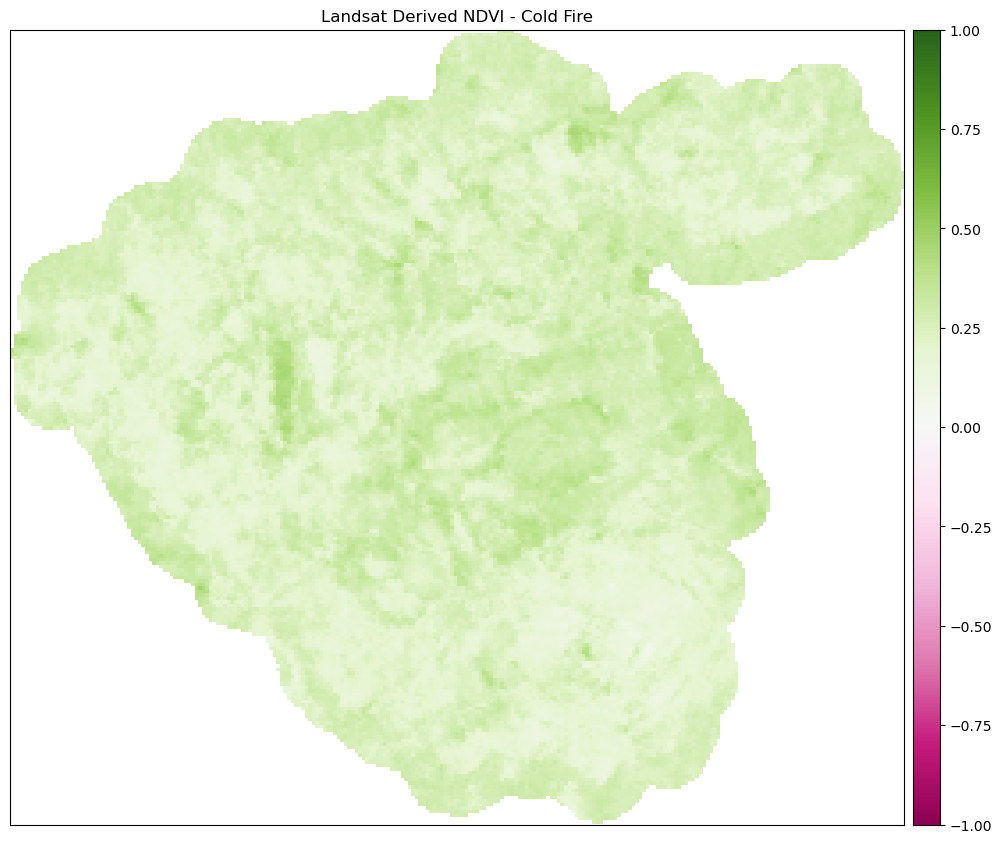

In [111]:
# plot last NDVI calculated
ep.plot_bands(ndvi,
              cmap='RdYlGn',
              scale=False,
              vmin=-1, vmax=1,
              title="Landsat-Derived NDVI - Cold Fire")
plt.show()

In [120]:
# get list of NDVI rasters in calcuated folder
os.chdir(calc_path)
calc_rasters = glob.glob('*[0-9].TIF')

print(calc_rasters)

['NDVI_2008_06_05.tif', 'NDVI_2008_09_02.tif', 'NDVI_2009_06_24.tif', 'NDVI_2010_07_06.tif', 'NDVI_2011_07_16.tif', 'NDVI_2013_06_28.tif', 'NDVI_2014_06_22.tif', 'NDVI_2015_06_25.tif', 'NDVI_2016_06_20.tif', 'NDVI_2017_06_23.tif', 'NDVI_2018_06_26.tif', 'NDVI_2019_06_29.tif', 'NDVI_2020_07_01.tif', 'NDVI_2021_06_18.tif', 'NDVI_2022_06_29.tif']


Notice the rasters are not in order. They need to be put in order before stacking them for time series purposes.

In [121]:
# sort rasters
calc_rasters.sort()

print(calc_rasters)

['NDVI_2008_06_05.tif', 'NDVI_2008_09_02.tif', 'NDVI_2009_06_24.tif', 'NDVI_2010_07_06.tif', 'NDVI_2011_07_16.tif', 'NDVI_2013_06_28.tif', 'NDVI_2014_06_22.tif', 'NDVI_2015_06_25.tif', 'NDVI_2016_06_20.tif', 'NDVI_2017_06_23.tif', 'NDVI_2018_06_26.tif', 'NDVI_2019_06_29.tif', 'NDVI_2020_07_01.tif', 'NDVI_2021_06_18.tif', 'NDVI_2022_06_29.tif']


In [119]:
# stack and save rasters
# read metadata of first file
with rasterio.open(calc_rasters[0]) as src0:
    meta = src0.meta

# update meta to reflect the number of rasters
meta.update(count = len(calc_rasters))

# read each raster and write it to stack
with rasterio.open('ndvi_stack.tif', 'w', **meta) as dst:
    for id, layer in enumerate(calc_rasters, start=1):
        with rasterio.open(layer) as src1:
            dst.write_band(id, src1.read(1))
            
# note nan values are no longer masked

## Calculate dNDVI, stack all dNDVI rasters, and export using rioxarray and rasterio
dNDVI = NDVI pre-fire - NDVI post-fire

In [5]:
# path for stacked NDVIs
ndvi_stack_path = os.path.join(calc_path, 'ndvi_stack.tif')

In [280]:
# this list won't be used to calculate NDVI,
# but it will be used to name the new rasters
os.chdir(calc_path)
calc_rasters = glob.glob('*[0-9].TIF')

print(calc_rasters)

['NDVI_2008_06_05.tif', 'NDVI_2008_09_02.tif', 'NDVI_2009_06_24.tif', 'NDVI_2010_07_06.tif', 'NDVI_2011_07_16.tif', 'NDVI_2013_06_28.tif', 'NDVI_2014_06_22.tif', 'NDVI_2015_06_25.tif', 'NDVI_2016_06_20.tif', 'NDVI_2017_06_23.tif', 'NDVI_2018_06_26.tif', 'NDVI_2019_06_29.tif', 'NDVI_2020_07_01.tif', 'NDVI_2021_06_18.tif', 'NDVI_2022_06_29.tif']


In [271]:
# read stacked NDVI raster
ndvi_stack = rxr.open_rasterio(ndvi_stack_path)

Since the NDVI rasters were sorted before stacking, the first raster is pre-fire, as can be seen in the calc_rasters list.

In [275]:
pre_fire = ndvi_stack[0]

The second raster in the stack is 2008 post-fire, which isn't useful (probably didn't need to calculate NDVI for it, oops)

In [282]:
for i in range(2, len(ndvi_stack)):
    # output path name
    dndvi_path = os.path.join(calc_path, 'd' + calc_rasters[i])
    
    # calculate dNDVI
    dndvi = pre_fire - ndvi_stack[i]
    
    # export raster
    dndvi.rio.to_raster(dndvi_path)

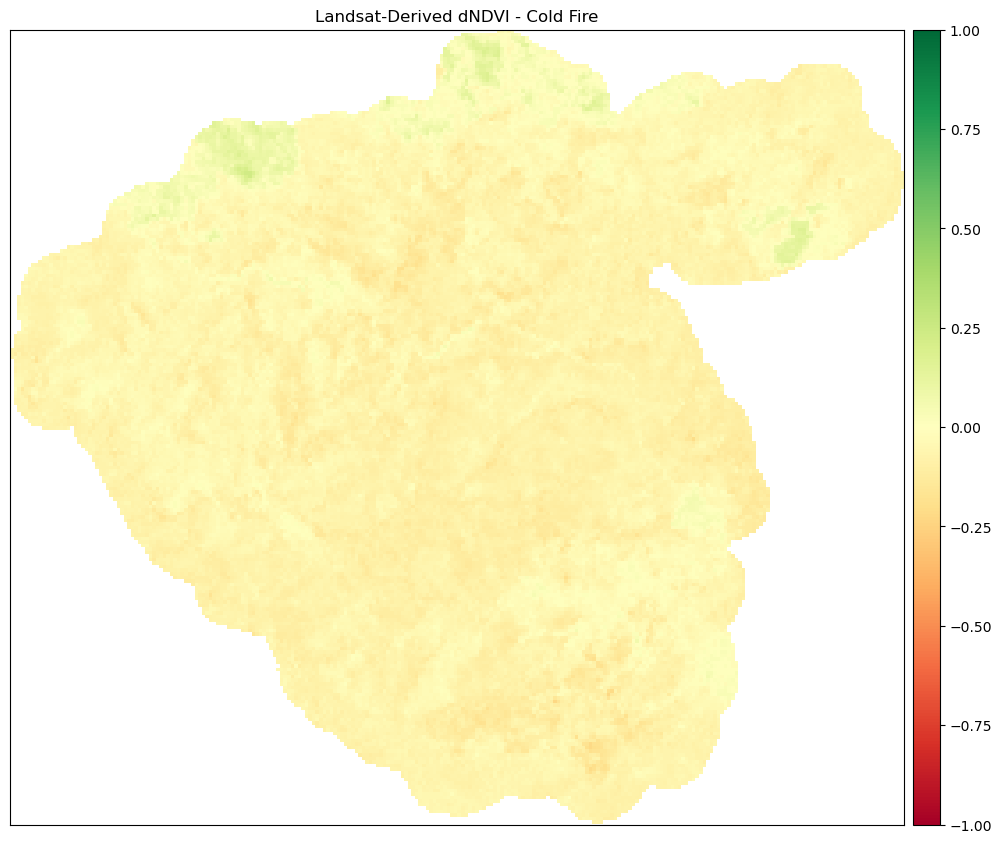

In [287]:
# plot last dNDVI calculated
ep.plot_bands(dndvi,
              cmap='RdYlGn',
              scale=False,
              vmin=-1, vmax=1,
              title="Landsat-Derived dNDVI - Cold Fire")
plt.show()

In [290]:
# get list of NDVI rasters in calcuated folder
os.chdir(calc_path)
dndvi_rasters = glob.glob('dNDVI*.tif')

print(dndvi_rasters)

['dNDVI_2009_06_24.tif', 'dNDVI_2010_07_06.tif', 'dNDVI_2011_07_16.tif', 'dNDVI_2013_06_28.tif', 'dNDVI_2014_06_22.tif', 'dNDVI_2015_06_25.tif', 'dNDVI_2016_06_20.tif', 'dNDVI_2017_06_23.tif', 'dNDVI_2018_06_26.tif', 'dNDVI_2019_06_29.tif', 'dNDVI_2020_07_01.tif', 'dNDVI_2021_06_18.tif', 'dNDVI_2022_06_29.tif']


In [291]:
# stack and save rasters
# read metadata of first file
with rasterio.open(dndvi_rasters[0]) as src0:
    meta = src0.meta

# update meta to reflect the number of rasters
meta.update(count = len(dndvi_rasters))

# read each raster and write it to stack
with rasterio.open('dndvi_stack.tif', 'w', **meta) as dst:
    for id, layer in enumerate(dndvi_rasters, start=1):
        with rasterio.open(layer) as src1:
            dst.write_band(id, src1.read(1))
            
# note nan values are no longer masked

## Reproject and clip SRTM DEM, calculate aspect and slope, and export rasters using GDAL

In [6]:
# SRTM DEM path
srtm_path = os.path.join(path, 'SRTM')
dem_path = os.path.join(srtm_path, 'SRTM_n39_w121_1arc_v2.tif')

In [22]:
# load DEM
dem = gdal.Open(dem_path)

In [7]:
# create output path for projected and clipped DEM
dem_clip_path = os.path.join(srtm_path, 'dem_clipped.tif')

In [28]:
# reproject and clip DEM
dem_clip = gdal.Warp(dem_clip_path, 
                     dem,
                     dstSRS='EPSG:26910',
                     resampleAlg='bilinear',
                     format='GTiff',
                     cutlineDSName=shp_clip, 
                     cropToCutline=True,
                     dstNodata='nan')

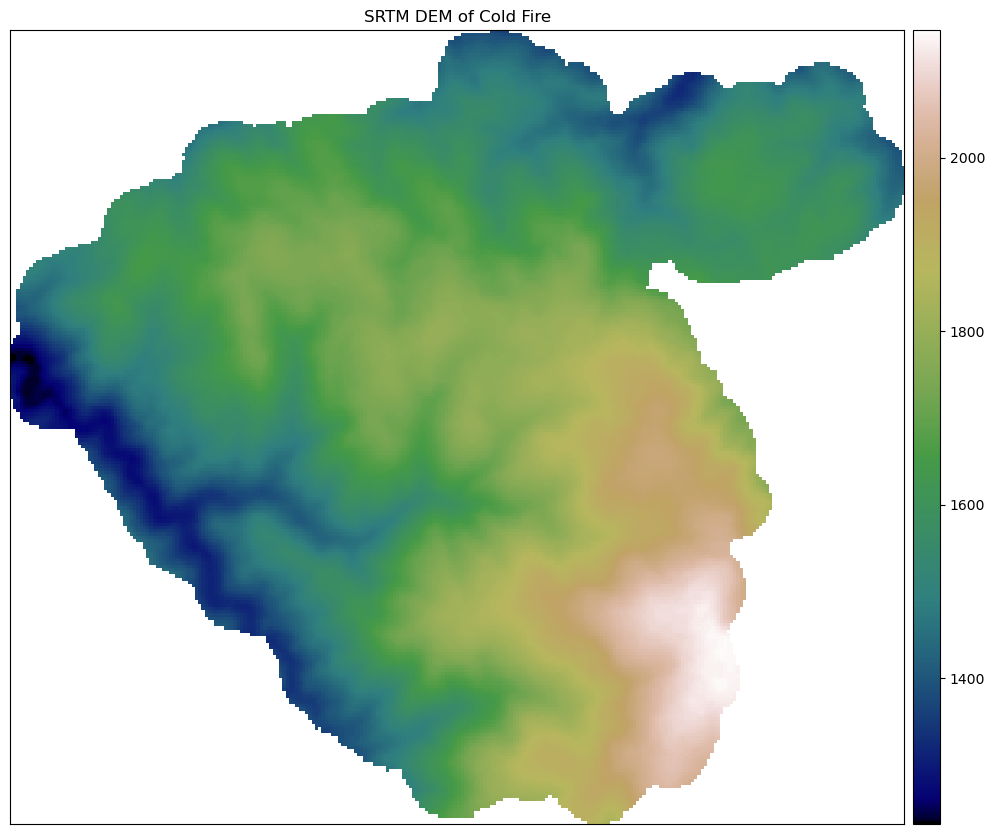

<Axes: title={'center': 'SRTM DEM of Cold Fire'}>

In [159]:
# plot reprojected and clipped DEM using rioxarray and earthpy
dem_clip_rxr = rxr.open_rasterio(dem_clip_path)

# mask pixels outside of shapefile boundary
valid_range = (0, dem_clip_rxr.max())
if valid_range:
    mask = ((dem_clip_rxr <= valid_range[0]) | (dem_clip_rxr > valid_range[1]))
    dem_mask = dem_clip_rxr.where(~xr.where(mask, True, False))
            
ep.plot_bands(dem_mask,
              cmap='gist_earth',
              title="SRTM DEM of Cold Fire")

In [117]:
# aspect output path
aspect_py_path = os.path.join(srtm_path, 'aspect_py.tif')

In [118]:
# calculate aspect and export raster
aspect_py = gdal.DEMProcessing(aspect_py_path, 
                            dem_clip_path, 
                            processing='aspect', 
                            format='GTiff',
                            band=1)

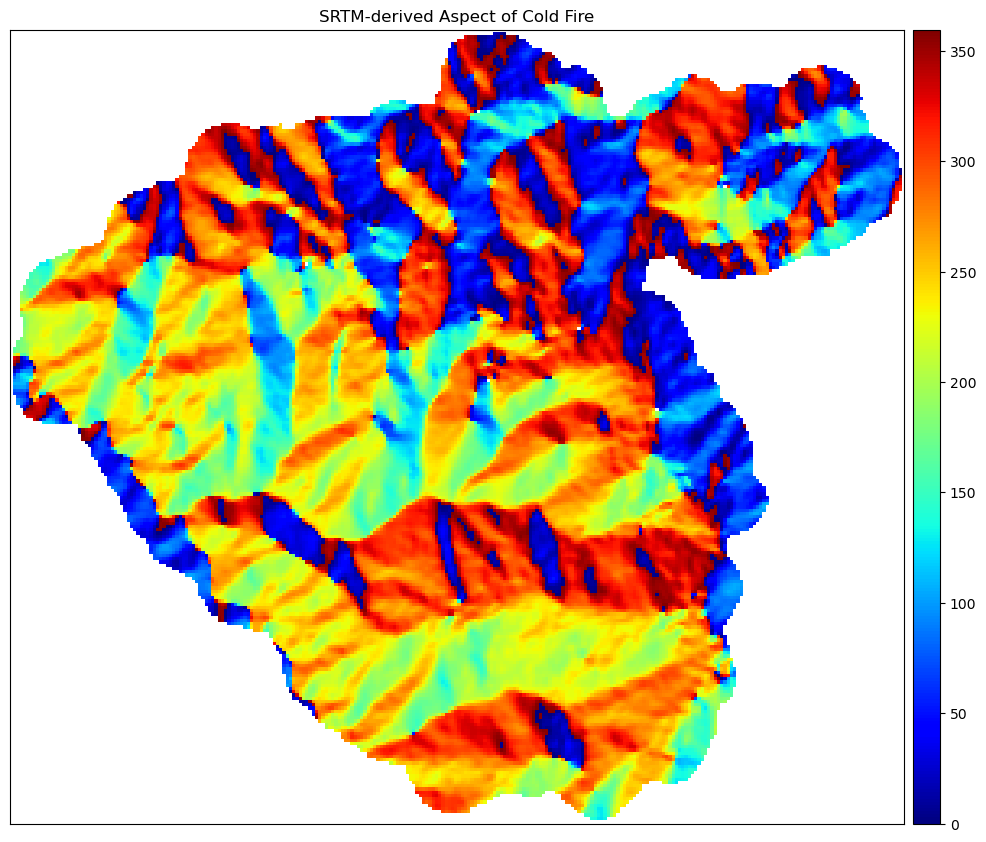

<Axes: title={'center': 'SRTM-derived Aspect of Cold Fire'}>

In [144]:
# plot aspect using rioxarray and earthpy
aspect_py_rxr = rxr.open_rasterio(aspect_py_path)

# mask pixels outside of shapefile boundary
valid_range = (0, aspect_py_rxr.max())
if valid_range:
    mask = ((aspect_py_rxr < valid_range[0]) | (aspect_py_rxr > valid_range[1]))
    aspect_mask = aspect_py_rxr.where(~xr.where(mask, True, False))
            
ep.plot_bands(aspect_mask,
              cmap='jet',
              vmin=0,
              title="SRTM-derived Aspect of Cold Fire")

In [35]:
# masked aspect raster output path
aspect_mask_path = os.path.join(srtm_path, 'aspect_mask.tif')

In [163]:
# export masked aspect raster
aspect_mask.rio.to_raster(aspect_mask_path)

In [121]:
# slope output path
slope_py_path = os.path.join(srtm_path, 'slope_py.tif')

In [122]:
# calculate slope and export raster
slope_py = gdal.DEMProcessing(slope_py_path, 
                            dem_clip_path, 
                            processing='slope', 
                            format='GTiff',
                            band=1,
                            scale=1.0)

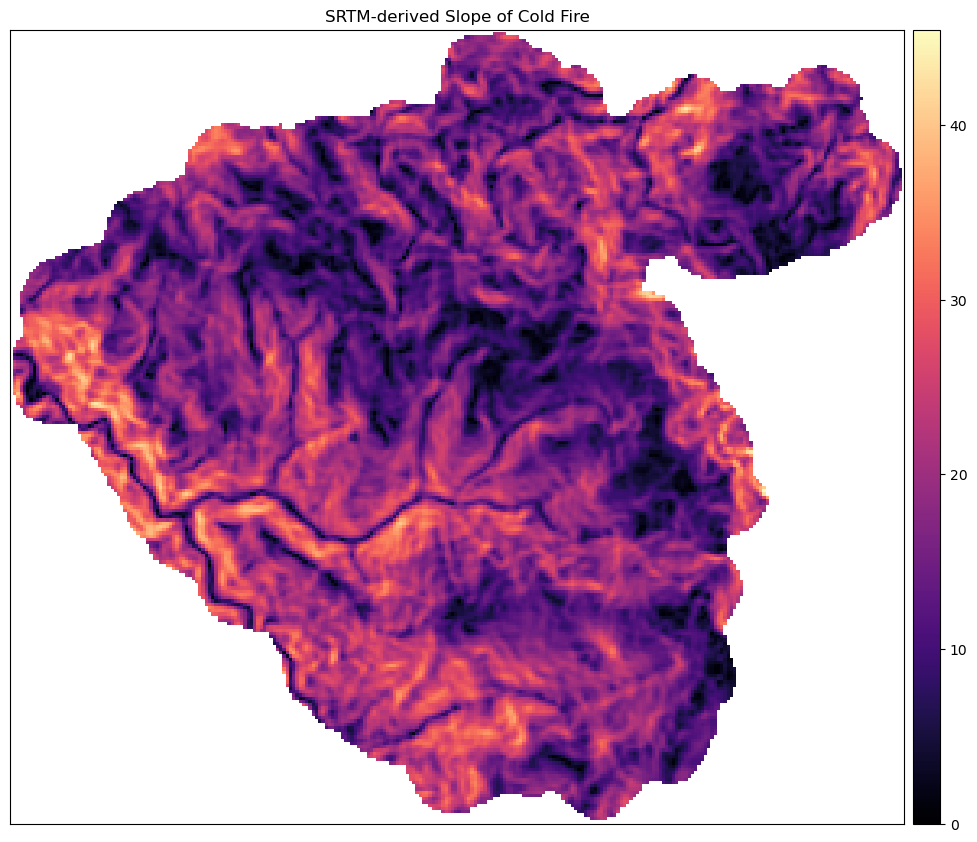

<Axes: title={'center': 'SRTM-derived Slope of Cold Fire'}>

In [142]:
# plot aspect using rioxarray and earthpy
slope_py_rxr = rxr.open_rasterio(slope_py_path)

# mask pixels outside of shapefile boundary
valid_range = (0, slope_py_rxr.max())
if valid_range:
    mask = ((slope_py_rxr < valid_range[0]) | (slope_py_rxr > valid_range[1]))
    slope_mask = slope_py_rxr.where(~xr.where(mask, True, False))
            
ep.plot_bands(slope_mask,
              cmap='magma',
              vmin=0,
              title="SRTM-derived Slope of Cold Fire")

In [59]:
# slope mask output path
slope_mask_path = os.path.join(srtm_path, 'slope_mask.tif')

In [215]:
# export masked slope raster
slope_mask.rio.to_raster(slope_mask_path)

## Clip and export aspect and slope rasters to make a raster for each class using rioxarray
To compare the relationship between vegetation regrowth and topography, slope and aspect need to be reclassified, and a raster for each class needs to be created.

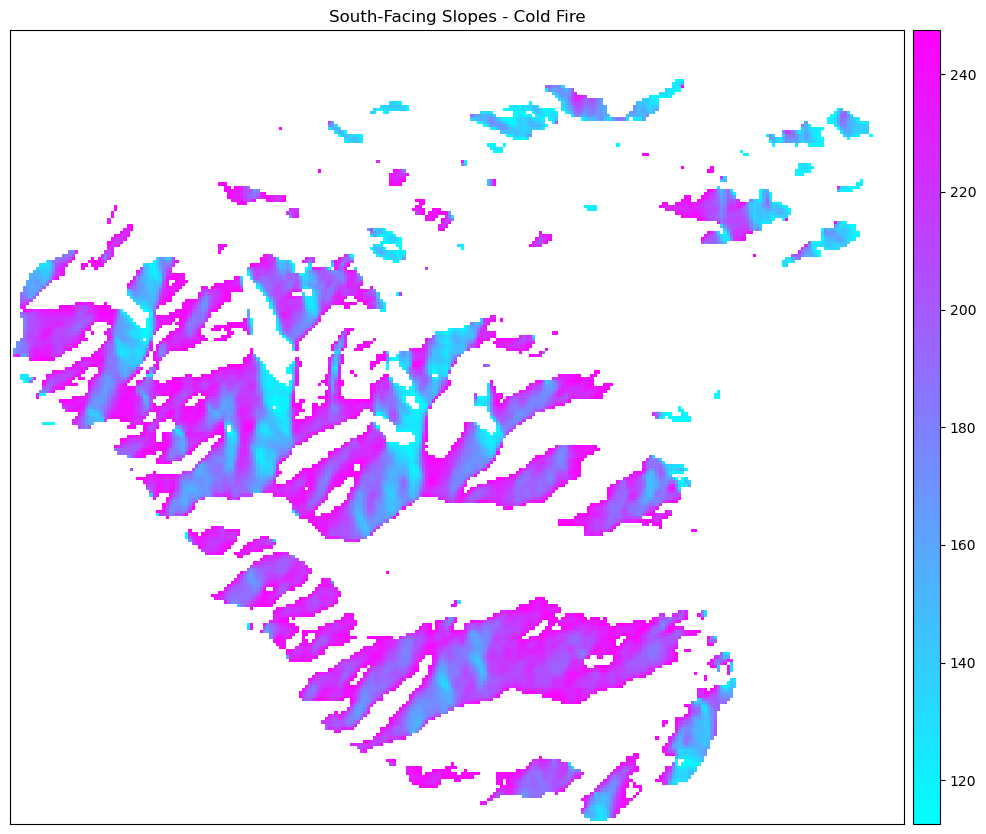

<Axes: title={'center': 'South-Facing Slopes - Cold Fire'}>

In [49]:
# open aspect raster
aspect_mask_in = rxr.open_rasterio(aspect_mask_path)

# south-facing slopes
valid_range = (112.5, 247.5)
if valid_range:
    mask = ((aspect_mask_in < valid_range[0]) | (aspect_mask_in > valid_range[1]))
    south_aspect = aspect_mask_in.where(~xr.where(mask, True, False))

# plot to verify
ep.plot_bands(south_aspect,
              cmap='cool',
              title="South-Facing Slopes - Cold Fire")

In [50]:
# create south aspect path
south_path = os.path.join(srtm_path, 'south_aspect.tif')

In [51]:
# export classified aspect raster
south_aspect.rio.to_raster(south_path)

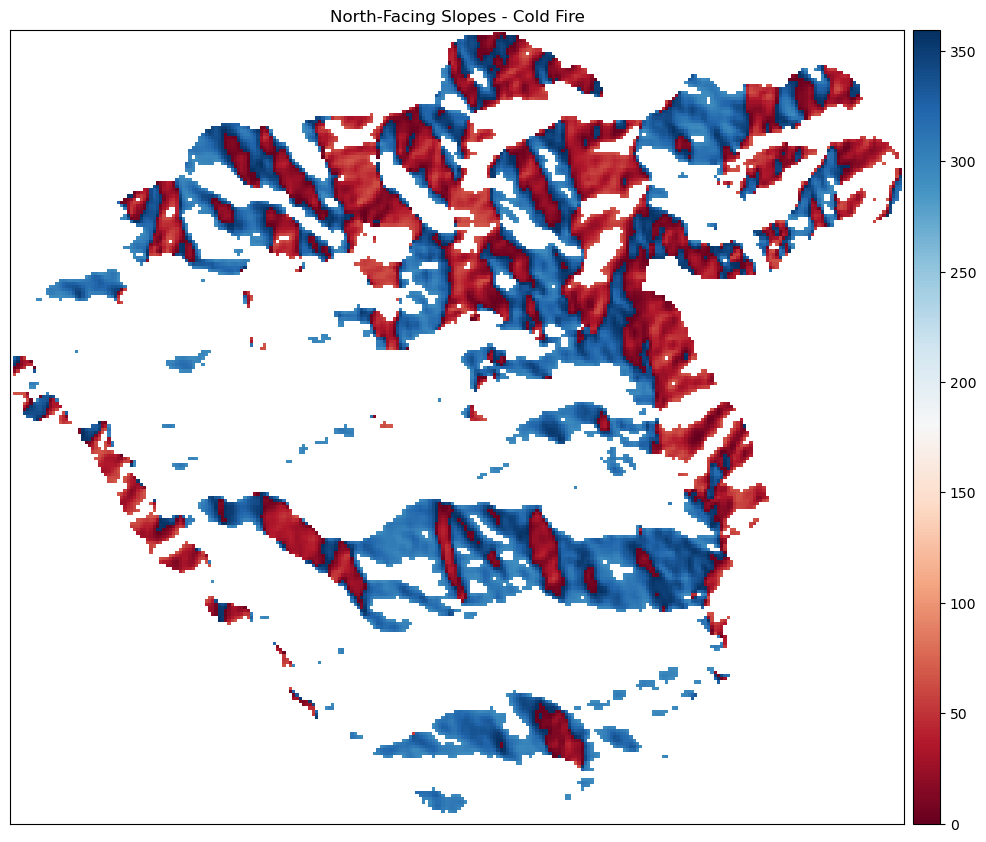

<Axes: title={'center': 'North-Facing Slopes - Cold Fire'}>

In [55]:
# north-facing slopes
valid_range = (0, 67.5, 292.5, 360)
if valid_range:
    mask = ((aspect_mask_in < valid_range[0]) | 
            ((aspect_mask_in > valid_range[1]) & (aspect_mask_in < valid_range[2])) |
            (aspect_mask_in > valid_range[3]))
    north_aspect = aspect_mask_in.where(~xr.where(mask, True, False))
            
# plot to verify
ep.plot_bands(north_aspect,
              cmap='RdBu',
              title="North-Facing Slopes - Cold Fire")

In [56]:
# create north aspect path
north_path = os.path.join(srtm_path, 'north_aspect.tif')

In [57]:
# export classified aspect raster
north_aspect.rio.to_raster(north_path)

The table below was used to determine slope classification:<br>
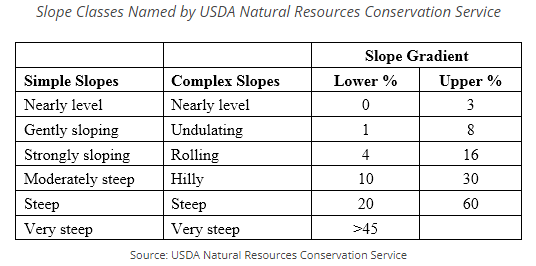<br>
Mild: 0 - 8%  
Moderate: 8 - 30%  
Steep: > 30%

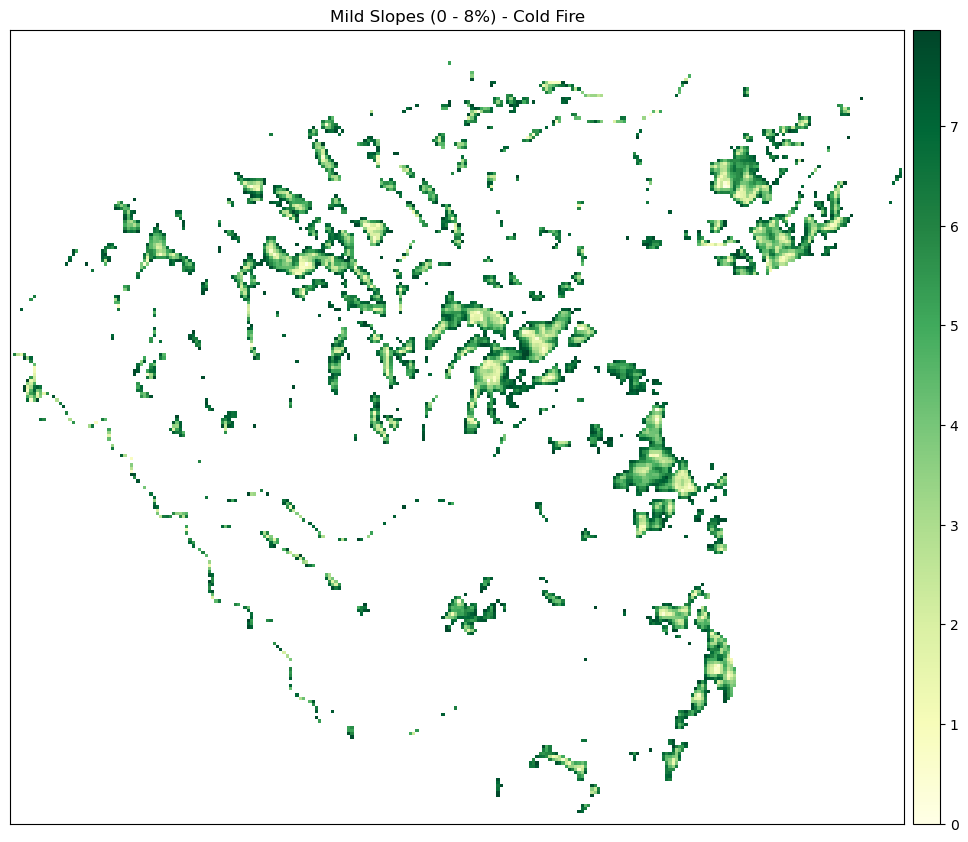

<Axes: title={'center': 'Mild Slopes (0 - 8%) - Cold Fire'}>

In [60]:
# open slope raster
slope_mask_in = rxr.open_rasterio(slope_mask_path)

# mild slopes
valid_range = (0, 8)
if valid_range:
    mask = ((slope_mask_in < valid_range[0]) | (slope_mask_in > valid_range[1]))
    mild_slope = slope_mask_in.where(~xr.where(mask, True, False))

# plot to verify
ep.plot_bands(mild_slope,
              cmap='YlGn',
              title="Mild Slopes (0 - 8%) - Cold Fire")

In [61]:
# create mild slope path
mild_path = os.path.join(srtm_path, 'mild_slope.tif')

In [63]:
# export classified slope raster
mild_slope.rio.to_raster(mild_path)

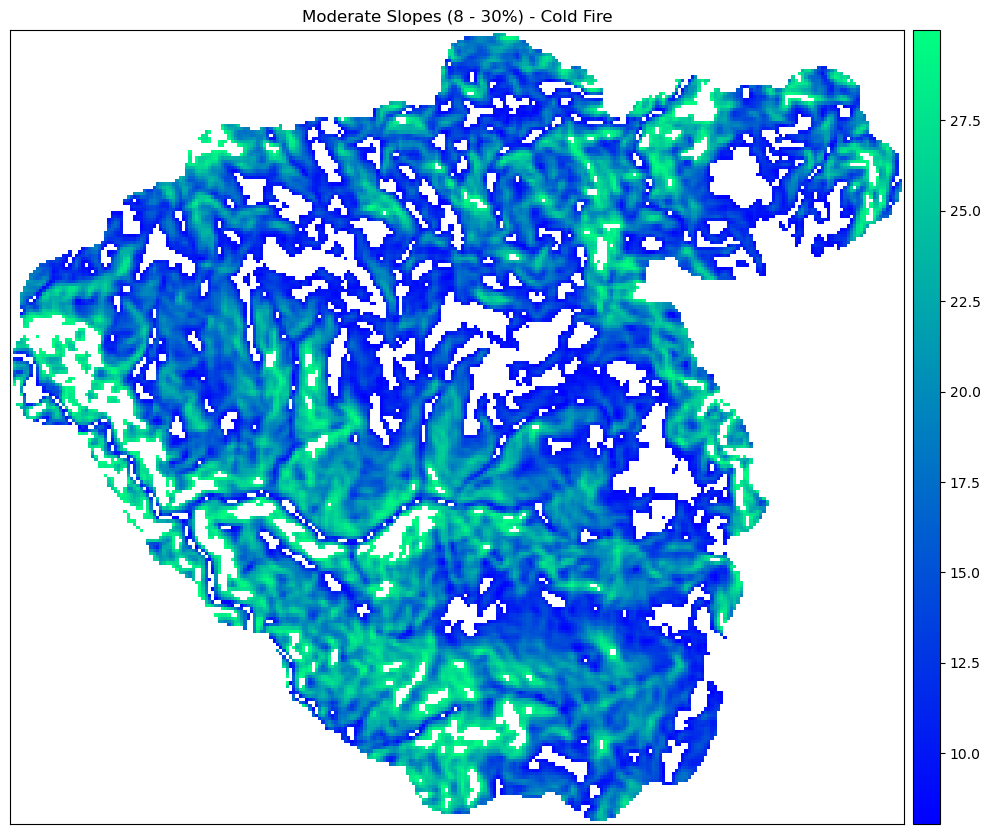

<Axes: title={'center': 'Moderate Slopes (8 - 30%) - Cold Fire'}>

In [65]:
# moderate slopes
valid_range = (8, 30)
if valid_range:
    mask = ((slope_mask_in <= valid_range[0]) | (slope_mask_in > valid_range[1]))
    mod_slope = slope_mask_in.where(~xr.where(mask, True, False))

# plot to verify
ep.plot_bands(mod_slope,
              cmap='winter',
              title="Moderate Slopes (8 - 30%) - Cold Fire")

In [66]:
# create moderate slope path
mod_path = os.path.join(srtm_path, 'mod_slope.tif')

In [67]:
# export classified slope raster
mod_slope.rio.to_raster(mod_path)

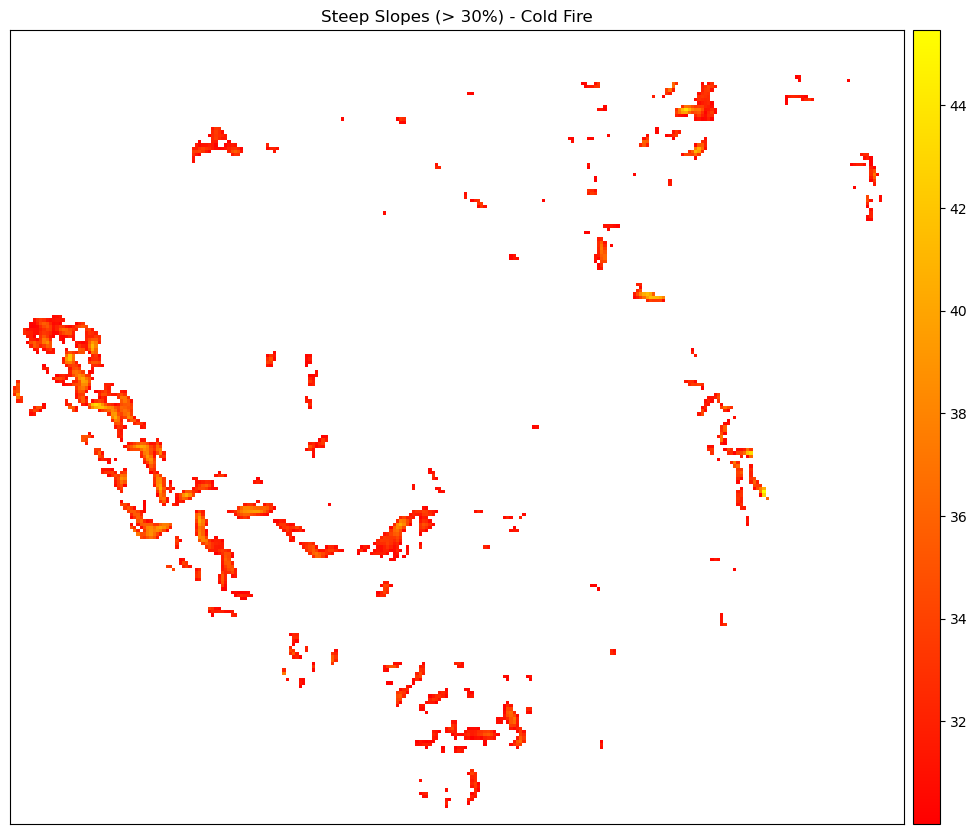

<Axes: title={'center': 'Steep Slopes (> 30%) - Cold Fire'}>

In [71]:
# moderate slopes
valid_range = (0, 30)
if valid_range:
    mask = ((slope_mask_in <= valid_range[1]))
    steep_slope = slope_mask_in.where(~xr.where(mask, True, False))

# plot to verify
ep.plot_bands(steep_slope,
              cmap='autumn',
              title="Steep Slopes (> 30%) - Cold Fire")

In [72]:
# create steep slope path
steep_path = os.path.join(srtm_path, 'steep_slope.tif')

In [73]:
# export classified slope raster
steep_slope.rio.to_raster(steep_path)

## Classify slope and aspect using rioxarray and xarray

In [36]:
# open masked aspect raster
aspect_in = rxr.open_rasterio(aspect_mask_path)

In [37]:
# create bins
# N, NE, NW for north-facing
# S, SE, SW for south-facing
# bins = north, east, south, west, north
aspect_bins = [0, 67.5, 112.5, 247.5, 292.5, 360]

In [38]:
# classify aspect using bins
aspect_class = xr.apply_ufunc(np.digitize, aspect_in, aspect_bins)

In [39]:
# only show desired classes
aspect_class_mask = aspect_class.where(aspect_class != 6)

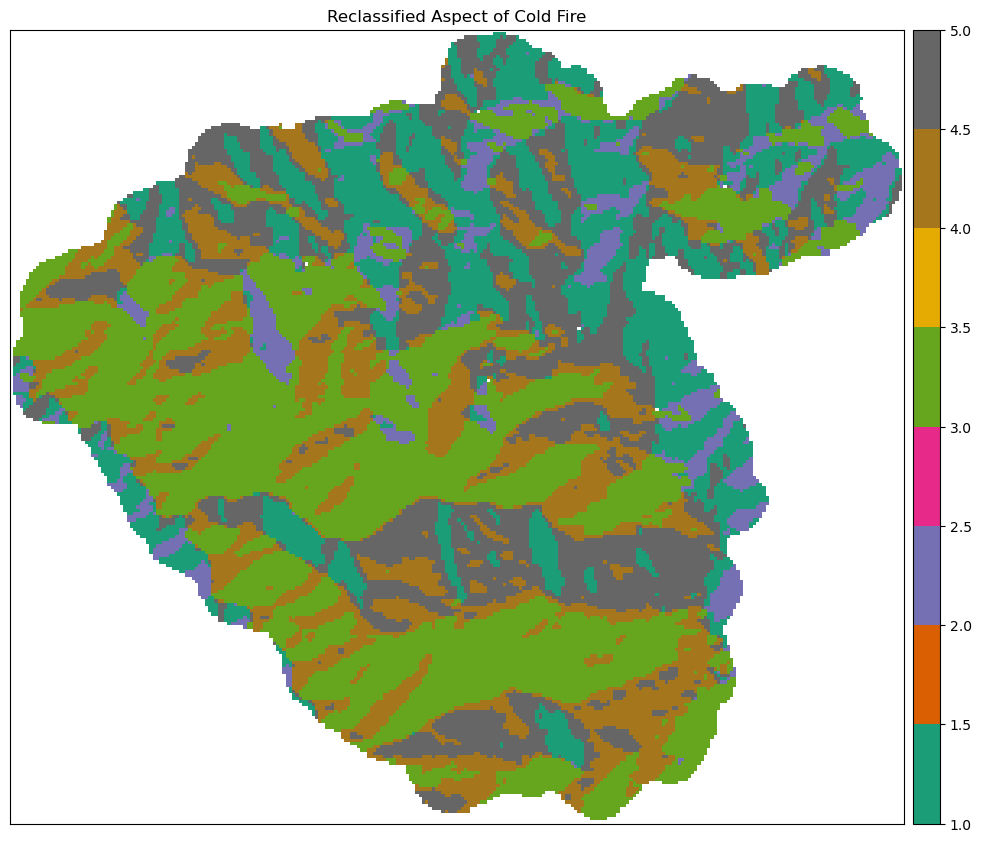

<Axes: title={'center': 'Reclassified Aspect of Cold Fire'}>

In [40]:
ep.plot_bands(aspect_class_mask,
              cmap='Dark2',
              title="Reclassified Aspect of Cold Fire")

In [43]:
type(aspect_class_mask)

xarray.core.dataarray.DataArray

In [8]:
# classified aspect output path
aspect_class_path = os.path.join(srtm_path, 'aspect_class.tif')

In [266]:
# export classified aspect raster
aspect_class_mask.rio.to_raster(aspect_class_path)

Now classify slope

In [257]:
# open masked slope raster
slope_in = rxr.open_rasterio(slope_mask_path)

In [254]:
# create bins
slope_bins = [0, 8, 30, slope_in.max()]

In [258]:
slope_class = xr.apply_ufunc(np.digitize, slope_in, slope_bins)

In [259]:
slope_class_mask = slope_class.where(slope_class != 4)

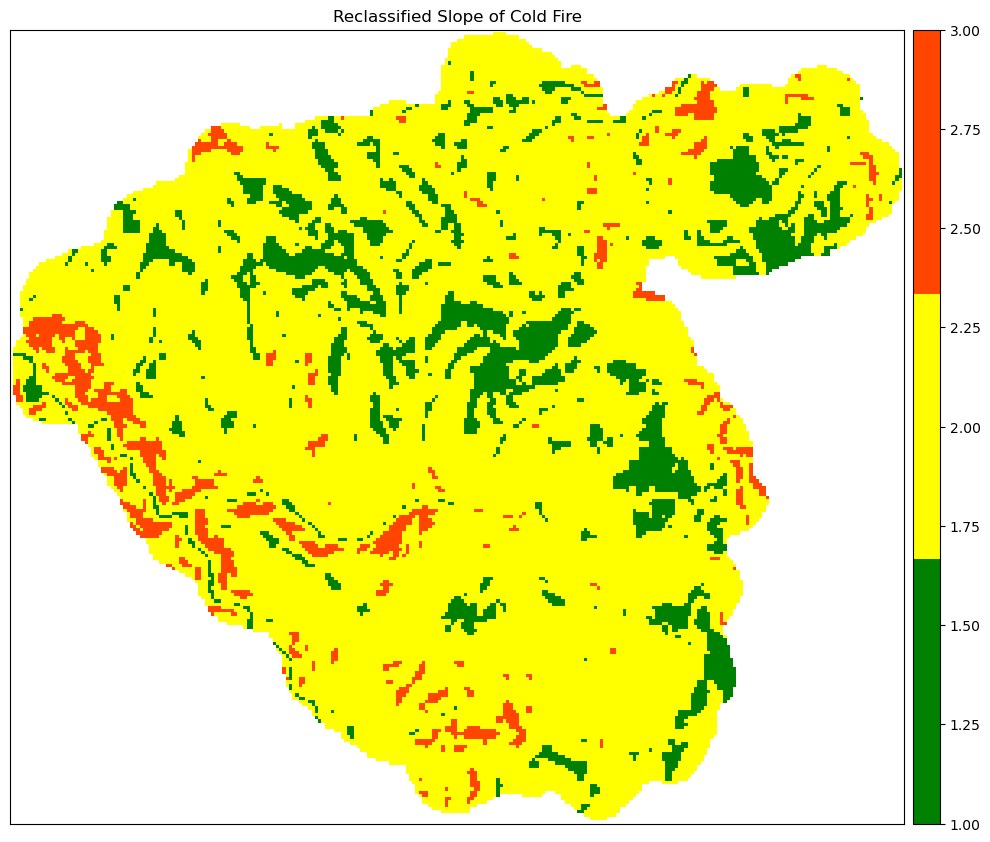

<Axes: title={'center': 'Reclassified Slope of Cold Fire'}>

In [264]:
slope_colors = 'green', 'yellow', 'orangered'
slope_cmap = ListedColormap(slope_colors)

ep.plot_bands(slope_class_mask,
              cmap=slope_cmap,
              title="Reclassified Slope of Cold Fire")

In [9]:
# classified slope output path
slope_class_path = os.path.join(srtm_path, 'slope_class.tif')

In [268]:
# export classified slope raster
slope_class_mask.rio.to_raster(slope_class_path)

## Perform NDVI linear regression analysis using scipy

In [21]:
# create path for an analysis folder
analysis_path = os.path.join(path, 'analysis')

In [22]:
# create analysis folder
os.mkdir(analysis_path)

In [11]:
# open NDVI stack
ndvi_stack = gdal.Open(os.path.join(calc_path, 'ndvi_stack.tif'))

In [12]:
# convert pre-fire raster to a numpy array
# GDAL RasterCount starts with 1, not 0
pre_fire = np.array(ndvi_stack.GetRasterBand(1).ReadAsArray())

# flatten the array
pre_fire_flat = pre_fire.flatten()

# remove nan values
pre_fire_clean = pre_fire_flat[~np.isnan(pre_fire_flat)]

In [27]:
# create a dataframe for the regressions stats
stats_df = pd.DataFrame(columns = ['Year', 
                                   'Slope', 
                                   'Intercept', 
                                   'R-value', 
                                   'P-value', 
                                   'Std_Err'])

In [23]:
# create path for image folder for scatterplots
img_path = os.path.join(analysis_path, 'images')

In [24]:
# create images folder
os.mkdir(img_path)

In [28]:
# create a function to save scatter plot of the data
def save_plot(post_clean, year):
    plt.scatter(pre_fire_clean, 
            post_clean, 
            15, 
            color='yellowgreen', 
            edgecolors='black', 
            linewidths=0.5)
    plt.xlabel('2008 Pre-fire NDVI')
    plt.ylabel(f'{year} NDVI')
    plt.xlim(0, 0.8)
    plt.ylim(0, 0.8)
    plt.axline((0,0), slope=1, color='black', ls='--', linewidth=1)
    plt.savefig(os.path.join(img_path, f'{year}_NDVI_plot.png'))

In [404]:
print(os.path.join(img_path, f'{year}_NDVI_plot.png'))

C:\Users\cowsp\OneDrive\ISU\Spring_23\GEOL6628\final_project\data\landsat\analysis\images\2023_NDVI_plot.png


In [29]:
# set the year variable to add to df
year = 2009

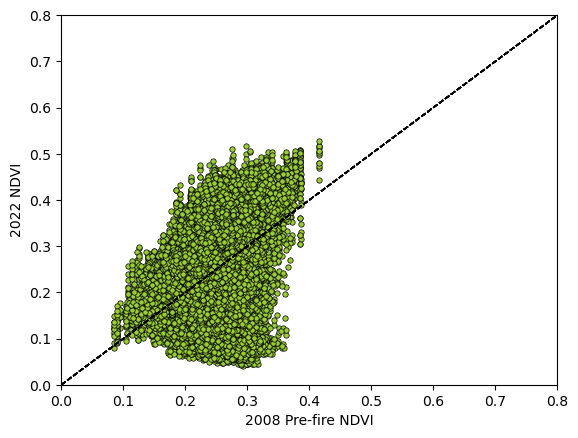

In [30]:
# run regression analysis, save the stats, create and save scatter plot
# don't need the 2008 post-fire NDVI
for i in range(3, ndvi_stack.RasterCount + 1):
    # convert raster to numpy array, flatten, and remove nan values
    post = np.array(ndvi_stack.GetRasterBand(i).ReadAsArray())
    post_flat = post.flatten()
    post_clean = post_flat[~np.isnan(post_flat)]
    
    # run regression analysis
    slope, intercept, r_value, p_value, std_err = stats.linregress(
    pre_fire_clean, post_clean)
    
    # add stats to df
    stats_df.loc[len(stats_df.index)] = [year, 
                             slope, 
                             intercept, 
                             r_value, 
                             p_value, 
                             std_err]
    
    # create and save plot
    save_plot(post_clean, year)
    
    # increment year but skip 2012
    year += 1
    
    if year == 2012:
        year += 1

In [31]:
stats_df

,Year,Slope,Intercept,R-value,P-value,Std_Err
0,2009.0,0.333625,0.094105,0.156677,2.079730e-190,0.011265
1,2010.0,0.605711,0.082671,0.292798,0.000000e+00,0.010595
2,2011.0,0.903110,0.018023,0.536911,0.000000e+00,0.007601
3,2013.0,0.913009,0.056445,0.553395,0.000000e+00,0.007360
4,2014.0,0.991358,0.024646,0.652115,0.000000e+00,0.006173
5,2015.0,0.999078,0.029387,0.660156,0.000000e+00,0.006089
6,2016.0,1.013771,0.055518,0.669309,0.000000e+00,0.006028
7,2017.0,1.036606,0.054888,0.700206,0.000000e+00,0.005661
8,2018.0,1.095777,0.046459,0.695065,0.000000e+00,0.006071
9,2019.0,1.027329,0.057387,0.712904,0.000000e+00,0.005413


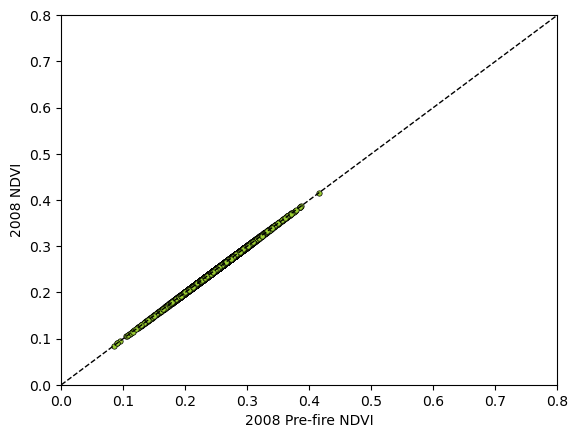

In [32]:
save_plot(pre_fire_clean, 2008)

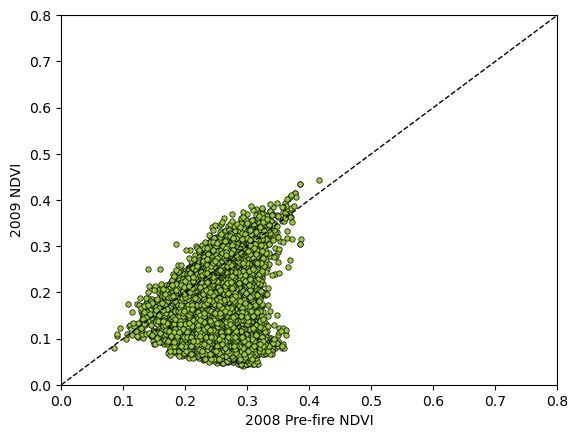

In [358]:
plt.scatter(pre_fire_clean, 
            post_clean, 
            15, 
            color='yellowgreen', 
            edgecolors='black', 
            linewidths=0.5)
plt.xlabel('2008 Pre-fire NDVI')
plt.ylabel('2009 NDVI')
plt.xlim(0, 0.8)
plt.ylim(0, 0.8)
plt.axline((0,0), slope=1, color='black', ls='--', linewidth=1)
plt.show()

array([0.30071749, 0.28147027, 0.26297715, ..., 0.35321528, 0.34865033,
       0.3403397 ])